## Credit Card Fraud Analysis
<a id="toc"></a>
### Intro

This is data set pulled from Kaggle with some basic machine learning in Python. Its a relatively small data set but paves the way for possiblities in the future.

https://www.kaggle.com/mlg-ulb/creditcardfraud


Per Kaggle regarding the data:

"It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

Acknowledgements:
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Citations:
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015


=======================================

This notebook covers the following:

[Logistic Regression](#logit)

[Light GBM](#lgb)

[AutoEncoder Neural Net](#aenn)

[Anomaly Detection](#ad)


### Metrics

- __Precision__ = True Fraud / (True Fraud + False Fraud)
    - This is the percentage of the results that are relevant.
    - For our purposes this is when we have accurately predicted actual fraud instances.
    - If this value is low then this could be a lot of resources spent researching the instances classified as Fraud.
    - The cost of False Fraud (investiagation expenses / customer loss) could be high.



- __Recall__ = True Fraud / (True Fraud + False Normal)
    - This is the percentage of total relevant results correctly classified.
    - This is the metric we focus on when there is a high cost associated with False Normals (i.e. the high cost of missing actual Fraud instances).
    


- The __F1-Score__ is a harmonic mean of the two scores above.


- There is also another formula for $ F_{\beta}$ which weights either Precision or Recall more heavily, that can be used for scoring the models.


- $ F_{\beta} = \frac{ (1+\beta^2)*(True Fraud)}{(1+\beta^2)*(True Fraud) + \beta^2*(False Fraud) + (False Normal)} $


- $\beta = 2$ would weight recall higher.
- $\beta = 0.5$ would weight precision higher.


Other Notes:

- Some of the code throughout this uses only a few highly correlated variables as an exmaple of feature refinement but that has been commented out.
- Some models are built on a kFold crossvalidation.
- The models are tested against binary classification (rather than probability of default) so as to compare them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, log_loss, recall_score, accuracy_score, classification_report
from sklearn.metrics import average_precision_score, roc_auc_score, auc, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import statsmodels.api as sma
import lightgbm as lgb
from collections import Counter

C:\Users\schillw\AppData\Local\Continuum\anaconda3\envs\fnb\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
## set random see
np.random.seed(42)

<font color='blue' size=4> The data was too large for Git so it can be downloaded from, https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv , and placed in a data folder.  </font>

In [4]:
df = pd.read_csv("data/creditcard.csv", index_col=0)
# print(df.columns)
print(df.head(3))

            V1        V2        V3        V4        V5        V6        V7  \
Time                                                                         
0.0  -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
0.0   1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
1.0  -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

            V8        V9       V10  ...         V21       V22       V23  \
Time                                ...                                   
0.0   0.098698  0.363787  0.090794  ...   -0.018307  0.277838 -0.110474   
0.0   0.085102 -0.255425 -0.166974  ...   -0.225775 -0.638672  0.101288   
1.0   0.247676 -1.514654  0.207643  ...    0.247998  0.771679  0.909412   

           V24       V25       V26       V27       V28  Amount  Class  
Time                                                                   
0.0   0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
0.0  -0.339846  0

In [5]:
print(df.shape)

(284807, 30)


This is a long data set but relatively skinny in the sense that there are only 29 non-target features.

In [6]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We have a dataframe about 284000 entries and they are floats data types and the data has been anonymized (as specified in the intro).

This data is very clean for our purposes.

In [7]:
class_count = Counter(df.Class)
print(class_count)

Counter({0: 284315, 1: 492})


The __Class__ feature is a binary target with 492 instances of known fraud and 284,315 instances of non-fraud. Thats a ratio of:

In [8]:
print("Fraud to NonFraud Ratio of {:.3f}%".format(class_count[1]/class_count[0]*100))

Fraud to NonFraud Ratio of 0.173%


Just from this we can see that there is a very low occurance of fraud in comparison with non fraud which could cause some issues should we dive into any kind of predictions. This is a common feature when attempting to model fraud.

In some instances, to improve the machine learning model, various Re-Sampling methods can be used in order to correct for bias. It is important to note that the resmapling methods here do not create replicas of already existing cases but rather samples the features in order to create new cases that are similar to some threshold to the originals. When using the __SMOTE__ method described below, it uses its K nearest neighbors.

Some points to consider are are __Undersampling__ and __Oversampling__ to _correct_ the proportions and for the models here we will stick to __OVER SAMPLING__ (specifically SMOTE or Syntheitc Minority Over-Sampling Technique) since it usually has better results for cases such as this.

- https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html


There are also more elaborate machine learning re-sampling methods such as SMOTEENN. This is a method of over sampling using SMOTE and then tidying up the data set using ENN or Edited Nearest Neighbors.

The ENN algorithm cleans up the over-sampled space by fine tuning the created samples and if necessary dropping ones that are outside of the calculated thresholds.

In [9]:
# fig, ax=plt.subplots(1,1,figsize=(12,6))
# df[df.Class==1]['Amount'].hist(bins=100,ax=ax); #,color='b');
# plt.title('Histogram of Fraud Amounts');
# plt.ylabel('Counts'); plt.xlabel('$');

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [11]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

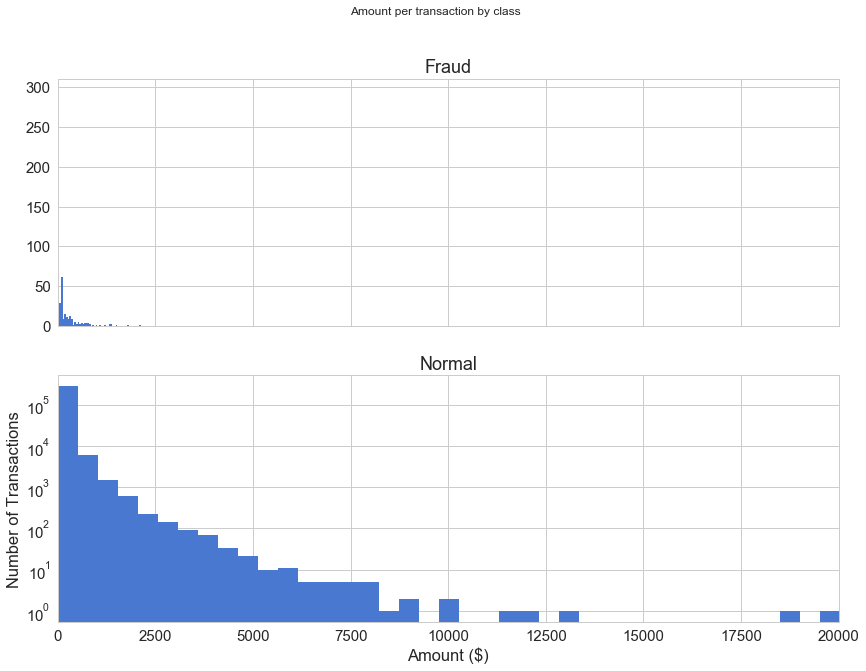

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10), sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

The size of the amount of the fraud transactions is small compared to the normal instances. This could be a sign of importance of _discreteness_ in the transaction amount. 

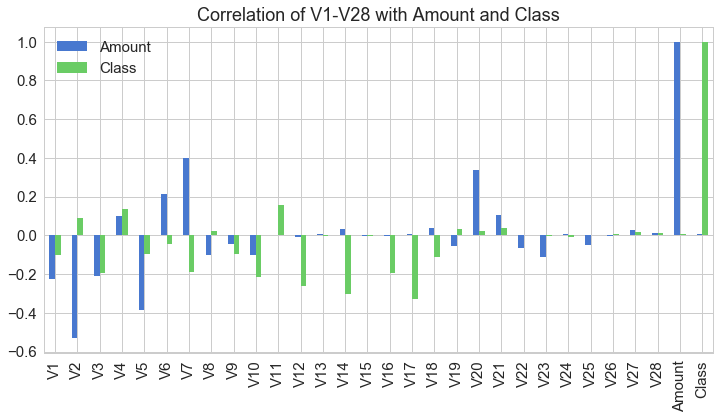

In [14]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
# sns.heatmap(df.corr(), vmin=-1, vmax=1, ax=ax, cmap='coolwarm');
df.corr()[['Amount','Class']].plot(kind='bar',ax=ax)
plt.title('Correlation of V1-V28 with Amount and Class');

The data set is transactions for many different accounts over time, but for this scenario we will assume the transactions are independent of each other.

There are other statistical features to take into consideration if we add in the time component.

In [15]:
## Scaling the Amount Column

ss = StandardScaler(with_mean=True, with_std=True)

df['Amount'] = ss.fit_transform(df['Amount'].values.reshape(-1,1))

## Oversampling and Train / Test Split

This is where one would create observations in the data set belonging to the class that has the lower occurence.

Lets do this using the `imblearn` package and _SMOTE_ or Syntheitc Minority Over-Sampling Technique.

We will split the full data set up 80/20 - train/test. Then we will over sample on the training set and test on the non-resampled validation set.



In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
y_full = df['Class']
x_full = df.drop(['Class'], axis=1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42)
print("Shape of Train and Test:")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print("Distribution of Instances in Test:")
print(Counter(y_test))

Shape of Train and Test:
(227845, 29) (227845,)
(56962, 29) (56962,)
Distribution of Instances in Test:
Counter({0: 56864, 1: 98})


Here we have split the data into a training set and a test set at 20%.

The 80% training set from the full data will be over-sampled and put through each model.

This over sampled data will then be split again at an 80/20 train/validation split for each model.

The original 20% test will be the non-over-sampled data which gives us us 98 instances of fraud to test against in each model method.

Its important to note that the methods used here in Sklearn split the data with purpose to retain the ratio in __Class__.

In [19]:
ism = SMOTE(random_state=42)

In [20]:
x_rs, y_rs = ism.fit_sample(x_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_rs)))

Resampled dataset shape Counter({0: 227451, 1: 227451})


In [21]:
x_rs = pd.DataFrame(x_rs, columns = x_full.columns)
y_rs = pd.DataFrame(y_rs)

This is an even balance. 

## Logistic Regression Classifier
<a id="logit"></a>
[TOC](#toc)

The logistic regression classifier is the typical work horse of these methods and can serve as a baseline for future modeling.

It can predict a binary target (0 or 1) or a probability of the target being a 0 or a 1.

In [22]:
kfolds = 3
kd = 0
lr_preds = 0
for i in range(kfolds):
    print('In kfold:',str(i+1))
    
    # the over sampled set
    xt,xv,yt,yv = train_test_split(x_rs, y_rs, test_size=0.2, random_state=(i*42))
       
    ## smaller values of C support stronger regularization
    lr_mod = LogisticRegression(C=0.9, random_state=(i*42)) #, n_jobs=3)
    lr_mod.fit(xt,yt.values.ravel())
    
    pred = lr_mod.predict(xv)
    pred_prob = lr_mod.predict_proba(x_test)
    lr_preds += pred_prob
    kd += 1
    print('=========================')
    print('Statistics on the OverSampled Train Set...')   
    print("Classification Report :")
    print(classification_report(yv, np.round(pred,0).astype(int)))
    print('=========================')
    
    pred0 = lr_mod.predict(x_test)
    print('=========================')
    print('Statistics on the Original Test Set...')
    print("Classification Report :")
    print(classification_report(y_test, np.round(pred0,0).astype(int)))
    print('=========================')    
    
lr_preds /= kfolds

In kfold: 1
Statistics on the OverSampled Train Set...
Classification Report :
             precision    recall  f1-score   support

          0       0.92      0.98      0.95     45666
          1       0.97      0.92      0.95     45315

avg / total       0.95      0.95      0.95     90981

Statistics on the Original Test Set...
Classification Report :
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56864
          1       0.06      0.92      0.11        98

avg / total       1.00      0.97      0.99     56962

In kfold: 2
Statistics on the OverSampled Train Set...
Classification Report :
             precision    recall  f1-score   support

          0       0.92      0.98      0.95     45398
          1       0.98      0.92      0.94     45583

avg / total       0.95      0.95      0.95     90981

Statistics on the Original Test Set...
Classification Report :
             precision    recall  f1-score   support

          0      

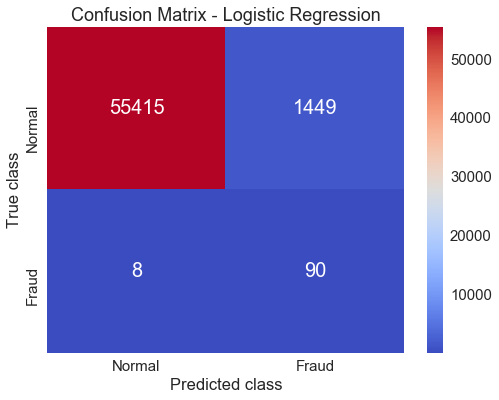

In [23]:
conf_matrix = confusion_matrix(y_test, np.round(lr_preds[:,1],0).astype(int))

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], 
            cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [24]:
print("Classification Report :")
lr_cr = classification_report(y_test, np.round(lr_preds[:,1],0).astype(int))
print(lr_cr)

Classification Report :
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56864
          1       0.06      0.92      0.11        98

avg / total       1.00      0.97      0.99     56962



The logistic regression identified 1539 instances of fraud, 90 of which were accurately predicted.

1449 were non-fraud and predicted fraud and 8 were fraud and predicted non-fraud.

Our Precision is low so that means we may have spent a lot more time and money using this model to track potential fraud cases, but our recall is quite high so we have definitely correctly identified 92% of cases.

## Light GBM 
<a id="lgb"></a>
[TOC](#toc)

This method is based on a Gradient Boosting Framework using decision trees.
This predicts a probability between 0 and 1 for each of the classes, where in this case there are only two.

- https://lightgbm.readthedocs.io/en/latest/

_There are other things you can do to improve the parameters for the model such as grid search estimation over cross validations._

In [25]:
def prob_to_bin(x, threshold=0.3):
    #function for thesholding predictions if less than 0.5
    x[x >= threshold] = 1
    x[x < threshold] = 0
    
    return x

In [26]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'learning_rate': 0.03, 
    'max_depth': -1,
    'num_leaves': 128, 
    'min_data_in_leaf': 64, 
    'lambda_l1': 1.0,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

print("Setting a Threshold of 0.3.")

kfolds = 3
kd = 0
lgb_preds = 0
for i in range(kfolds):
    print('In kfold:',str(i+1))
    # the over sampled set
    xt,xv,yt,yv = train_test_split(x_rs, y_rs, test_size=0.2, random_state=(i*42))
    
    trn = lgb.Dataset(xt,yt.values.flatten())
    val = lgb.Dataset(xv,yv.values.flatten())
    lgb_mod = lgb.train(params, train_set=trn, num_boost_round=200,
                     valid_sets=[val], valid_names=['val'],
                     verbose_eval=100,
                     early_stopping_rounds=100)
    
    pred = lgb_mod.predict(xv) #, num_iteration=lgb_mod.best_iteration+50)
    pred0 = lgb_mod.predict(x_test) #, num_iteration=lgb_mod.best_iteration+50)
    lgb_preds += pred0
    
    kd += 1
    print('=========================')
    print('Statistics on the OverSampled Train Set...')  
    print("Classification Report :")
    print(classification_report(yv, np.round(pred,0).astype(int)))
    print('=========================')
    
    p2b0 = prob_to_bin(pred0)
    print('=========================')
    print('Statistics on the Original Test Set...')          
    print("Classification Report :")
    print(classification_report(y_test, p2b0))
    print('=========================')    
    
lgb_preds /= kfolds

Setting a Threshold of 0.3.
In kfold: 1
Training until validation scores don't improve for 100 rounds.
[100]	val's binary_logloss: 0.0347709
[200]	val's binary_logloss: 0.00417236
Did not meet early stopping. Best iteration is:
[200]	val's binary_logloss: 0.00417236
Statistics on the OverSampled Train Set...
Classification Report :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     45666
          1       1.00      1.00      1.00     45315

avg / total       1.00      1.00      1.00     90981

Statistics on the Original Test Set...
Classification Report :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.55      0.89      0.68        98

avg / total       1.00      1.00      1.00     56962

In kfold: 2
Training until validation scores don't improve for 100 rounds.
[100]	val's binary_logloss: 0.0351436
[200]	val's binary_logloss: 0.00422714
Did not meet early st

In [27]:
## Normalize the Feature Importances

fi = 100 * lgb_mod.feature_importance()/lgb_mod.feature_importance().max()
feats_df = pd.DataFrame(fi, index=x_train.columns, 
                        columns=['importance']).sort_values(by='importance', ascending=True)

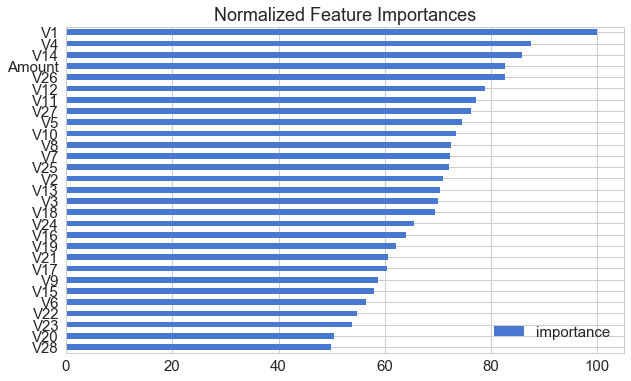

In [28]:
fig, ax=plt.subplots(1,1,figsize=(10,6))
feats_df.plot(kind='barh', ax=ax, color='C0', stacked=True);
plt.title("Normalized Feature Importances");

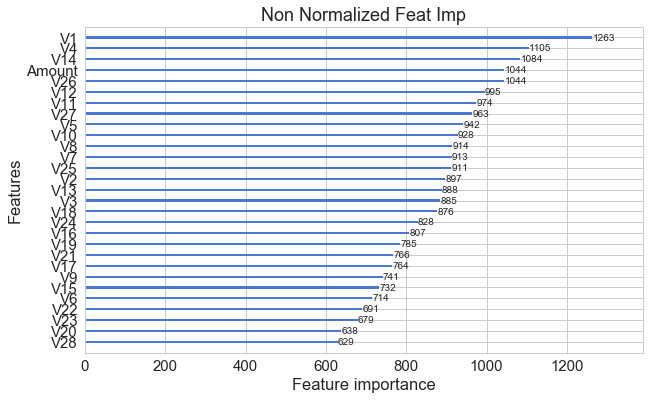

In [29]:
lgb.plot_importance(lgb_mod, figsize=(10,6));
plt.title("Non Normalized Feat Imp");

One highlight of the Light GBM and other Gradient Boosting methods is the ability to highlight feature importance.

This comes in handy when there is concern of scalability and with this you can trim out uneceesary features.

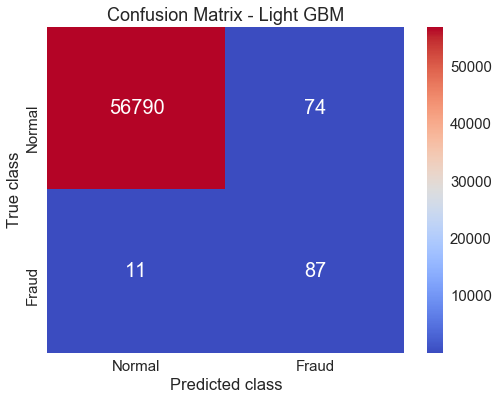

In [30]:
conf_matrix = confusion_matrix(y_test, prob_to_bin(lgb_preds))

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], 
            cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion Matrix - Light GBM")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [31]:
print("Classification Report :")
lgb_cr = classification_report(y_test, prob_to_bin(lgb_preds))
print(lgb_cr)

Classification Report :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.54      0.89      0.67        98

avg / total       1.00      1.00      1.00     56962



The LGB method predicted 159 cases of fraud, 87 of which were actual fraud.

Here we spent less time and effort identifying the fraud cases but also missed a few more than with the Logistic model.

## Neural Nets

Here we have a Neural Net example. 

Neural Networks hinge on their ability to learn much deeper patters in the data set but it helps to have a much larger data set in that regard. The data set here is just not that large. 

Additionally, they are a bit of a black box when it comes to development and there is a lot of trial and error.

Here will go with a simple example using tensorflow and Keras (both deep learning Python packages) in doing an AutoEncoder Neural Net with semi-supervised learning.

The AutoEncoder essentially compresses the data set (very handy if its large) and recreates it. The recreated data set is built with the understanding of feature importance relative to the features highly connected to the instances of fraud.

<a id="aenn"></a>
[TOC](#toc)

In [32]:
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

In [33]:
## split up the data
# the over sampled set

## delete the old ones incase they are lingering in memory
del xt, xv, yt, yv


xt,xv,yt,yv = train_test_split(x_rs, y_rs, test_size=0.2, random_state=(42))

In [34]:
input_dim = x_test.shape[1]
encoding_dim = 15 # Encoding with about half the featuress

In [35]:
print("--- Model Build ---")

input_layer = Input(shape=(input_dim,))

## First Dense Layer Encoder
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

## Second Dense Layer Encoder
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

## First layer Decoder
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)

## Second Layer Decoder
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

--- Model Build ---


In [36]:
## this will print out the model build
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                232       
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________
None


In [37]:

print("--- Run the Model ---")
print(" This will print out accuracy and validation accuracy for the over-sampled train set ... ")
print("\n")

nb_epoch = 50 #100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="data/model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(xt, xt,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(xv, xv),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

--- Run the Model ---
 This will print out accuracy and validation accuracy for the over-sampled train set ... 


Train on 363921 samples, validate on 90981 samples
Epoch 1/50
363921/363921 [==============================] - 8s 23us/step - loss: 11.5100 - acc: 0.5431 - val_loss: 11.2550 - val_acc: 0.6382
Epoch 2/50
363921/363921 [==============================] - 8s 23us/step - loss: 11.2418 - acc: 0.6844 - val_loss: 11.1982 - val_acc: 0.7173
Epoch 3/50
363921/363921 [==============================] - 8s 23us/step - loss: 11.2185 - acc: 0.7183 - val_loss: 11.1948 - val_acc: 0.7186
Epoch 4/50
363921/363921 [==============================] - 8s 22us/step - loss: 11.2122 - acc: 0.7250 - val_loss: 11.1935 - val_acc: 0.7288
Epoch 5/50
363921/363921 [==============================] - 8s 23us/step - loss: 11.2090 - acc: 0.7281 - val_loss: 11.1839 - val_acc: 0.7327
Epoch 6/50
363921/363921 [==============================] - 9s 24us/step - loss: 11.2061 - acc: 0.7298 - val_loss: 11.1857 - val_a

In [38]:
## this saves the model for future use and you would have to create a data
## folder in the location of this notebook, or change the path below
autoencoder = load_model('data/model.h5')

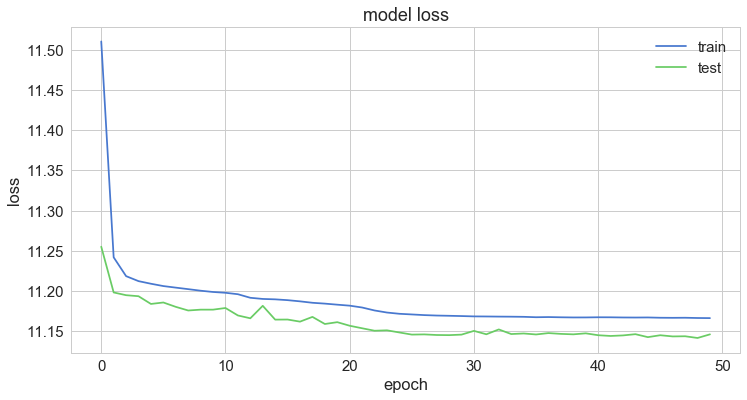

In [39]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Prediction on the AutoEncoder and Reconstruction using the Test Set

In [40]:
predictions = autoencoder.predict(x_test)

In [41]:
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [42]:
# fig , ax=plt.subplots(2,1,figsize=(12,10))
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
# _ = ax[0].hist(normal_error_df.reconstruction_error.values, bins=10)
# ax[0].set_title("Reconstruction Error w/o Fraud");
fraud_error_df = error_df[error_df['true_class'] == 1]
# _ = ax[1].hist(fraud_error_df.reconstruction_error.values, bins=10)
# ax[1].set_title("Reconstruction Error w Fraud");

These are some of the thresholds based on the percentile of the reconstruction error:

In [43]:
threshold_95p = np.percentile(normal_error_df.reconstruction_error.values, q=95)
threshold_97p = np.percentile(normal_error_df.reconstruction_error.values, q=97)
threshold_99p = np.percentile(normal_error_df.reconstruction_error.values, q=99)

print("95th Percentile Threshold :", threshold_95p)
print("97th Percentile Threshold :", threshold_97p)
print("99th Percentile Threshold :", threshold_99p)

95th Percentile Threshold : 1.47881443156
97th Percentile Threshold : 2.14469429429
99th Percentile Threshold : 4.55175739694


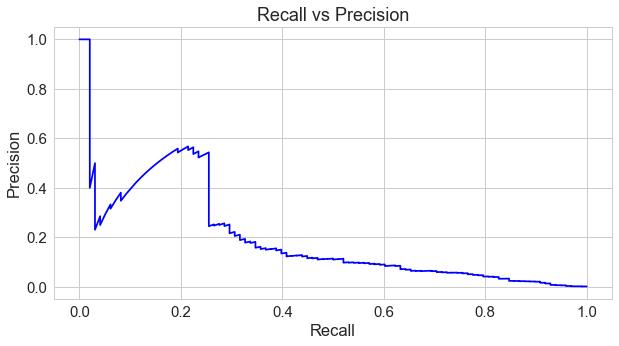

In [44]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
fig = plt.subplots(1,1,figsize=(10,5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision.

- High precision relates to a low false positive rate.
- High recall relates to a low false negative rate.

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).


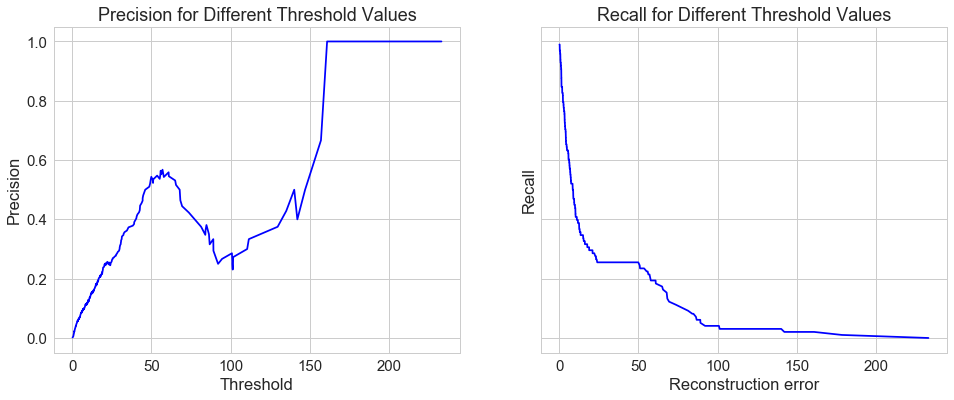

In [45]:
fig, ax=plt.subplots(1,2,figsize=(16,6), sharey=True)
ax[0].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
ax[0].set_title('Precision for Different Threshold Values')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Precision')
ax[1].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
ax[1].set_title('Recall for Different Threshold Values')
ax[1].set_xlabel('Reconstruction error')
ax[1].set_ylabel('Recall')
plt.show()

- As the reconstruction error increases our precision rises as well.
- As reconstruction error increases, recall decreases.

### Prediction on Unseen Data

The idea behind this is to set a threshold for the Reconstruction Error. Then where predictions are greater than the threshold, it will be marked as fraud.

In [46]:
threshold = threshold_95p
threshold = threshold_99p
# threshold = threshold_97p

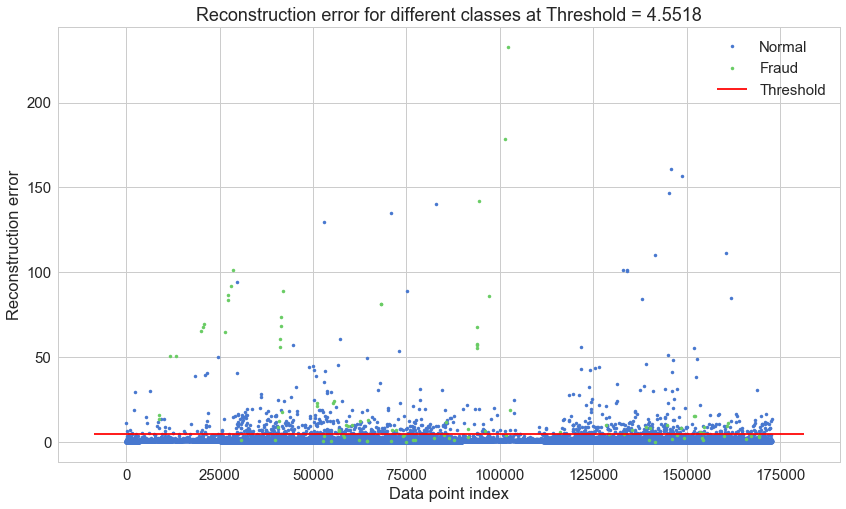

In [47]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(14,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes at Threshold = {:.4f}".format(threshold))
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

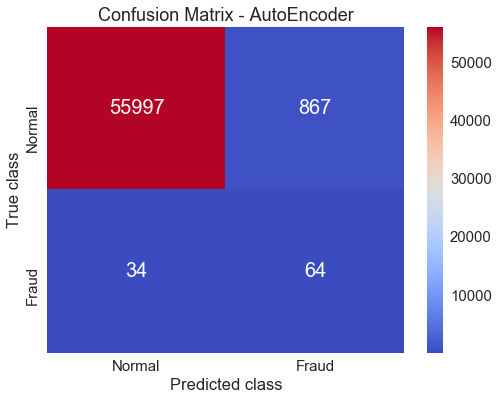

In [48]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], 
            cmap='coolwarm', annot=True, fmt="d",annot_kws={"size": 20});
plt.title("Confusion Matrix - AutoEncoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [52]:
print("Classification Report :")
aenn_cr = classification_report(error_df.true_class, y_pred)
print(aenn_cr)

Classification Report :
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56864
          1       0.07      0.65      0.12        98

avg / total       1.00      0.98      0.99     56962



This is just a basic model and could likely be improved with more data and further tuning.

However it did not fair well against the other models above.

## Other Metrics

In [49]:
pred_methods = [lr_preds[:,1], lgb_preds, np.array(y_pred)]
# [print(len(p)) for p in pred_methods]

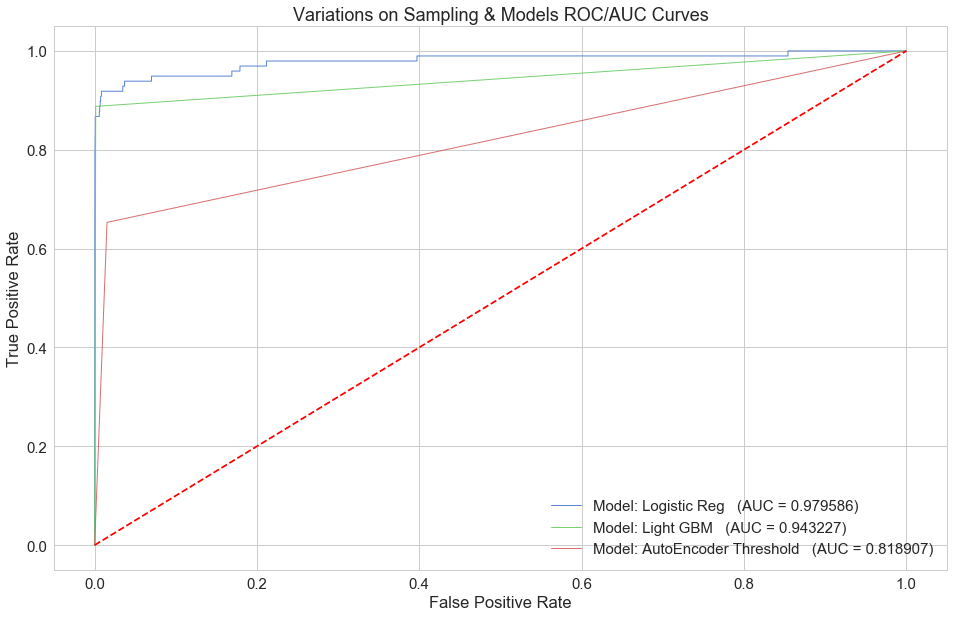

In [50]:
cols = ['C0','C1','C2']
pred_fits = ['Logistic Reg', 'Light GBM', 'AutoEncoder Threshold']
fig, ax=plt.subplots(1,1,figsize=(16,10))
plt.title('Variations on Sampling & Models ROC/AUC Curves');
for i in range(len(pred_methods)):
    fpr, tpr, thresholds = roc_curve(y_test, pred_methods[i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1, alpha=0.9, color=cols[i],
                 label='Model: %s   (AUC = %0.6f)' % (pred_fits[i], roc_auc))
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), 'r--');
ax.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');

Another method of examining the how well a model performs is to take a look at the ROC/AUC curve.

This measures the True Positive Rate vs the False Positive Rate and you want to maxmimize the areu under the curve (AUC).

This highlights the Logisitic Regression Classifier and Light GBM models as superior. However it doesn't take into account the other Recall and Precision.

In [53]:
print("Final Classification Reports:")
print("Logsitic Reg ==================================")
print(lr_cr)
print("Light GBM =====================================")
print(lgb_cr)
print("AutoEncoder NN ================================")
print(aenn_cr)

Final Classification Reports:
Logsitic Reg ==================================
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56864
          1       0.06      0.92      0.11        98

avg / total       1.00      0.97      0.99     56962

Light GBM =====================================
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.54      0.89      0.67        98

avg / total       1.00      1.00      1.00     56962

AutoEncoder NN ================================
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56864
          1       0.07      0.65      0.12        98

avg / total       1.00      0.98      0.99     56962



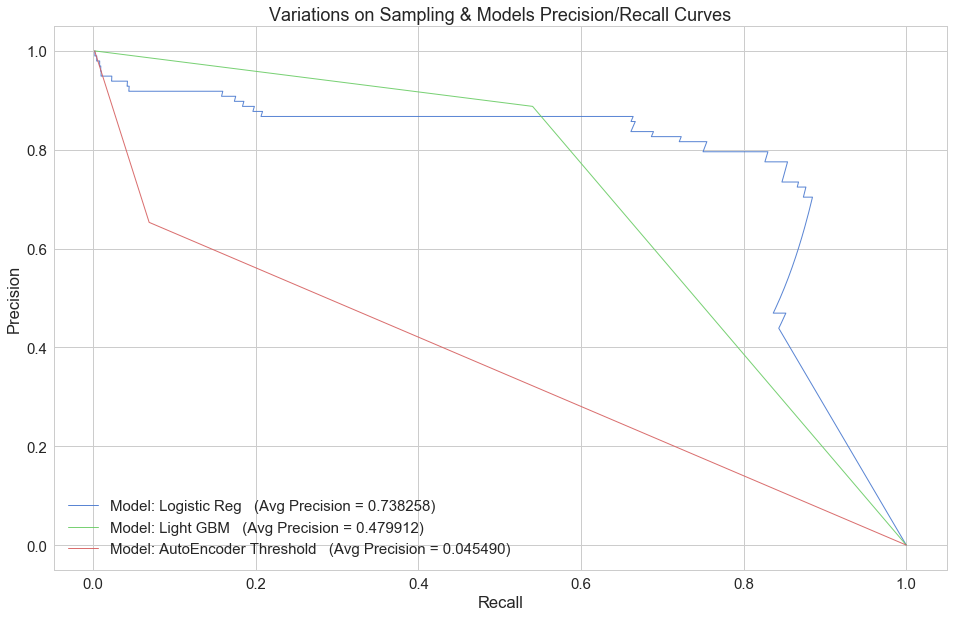

In [54]:
cols = ['C0','C1','C2']
pred_fits = ['Logistic Reg', 'Light GBM', 'AutoEncoder Threshold']
fig, ax=plt.subplots(1,1,figsize=(16,10))
plt.title('Variations on Sampling & Models Precision/Recall Curves');
for i in range(len(pred_methods)):
    prec, reca, tholds = precision_recall_curve(y_test, pred_methods[i])
    average_precision = average_precision_score(y_test, pred_methods[i])
    ax.plot(prec, reca, lw=1, alpha=0.9, color=cols[i], #label='Model: %s' % (pred_fits[i]))
                 label='Model: %s   (Avg Precision = %0.6f)' % (pred_fits[i], average_precision))
# ax.plot(np.linspace(1,0,100),np.linspace(1,0,100), 'r--');
ax.legend();
plt.xlabel('Recall'); plt.ylabel('Precision');